Working code

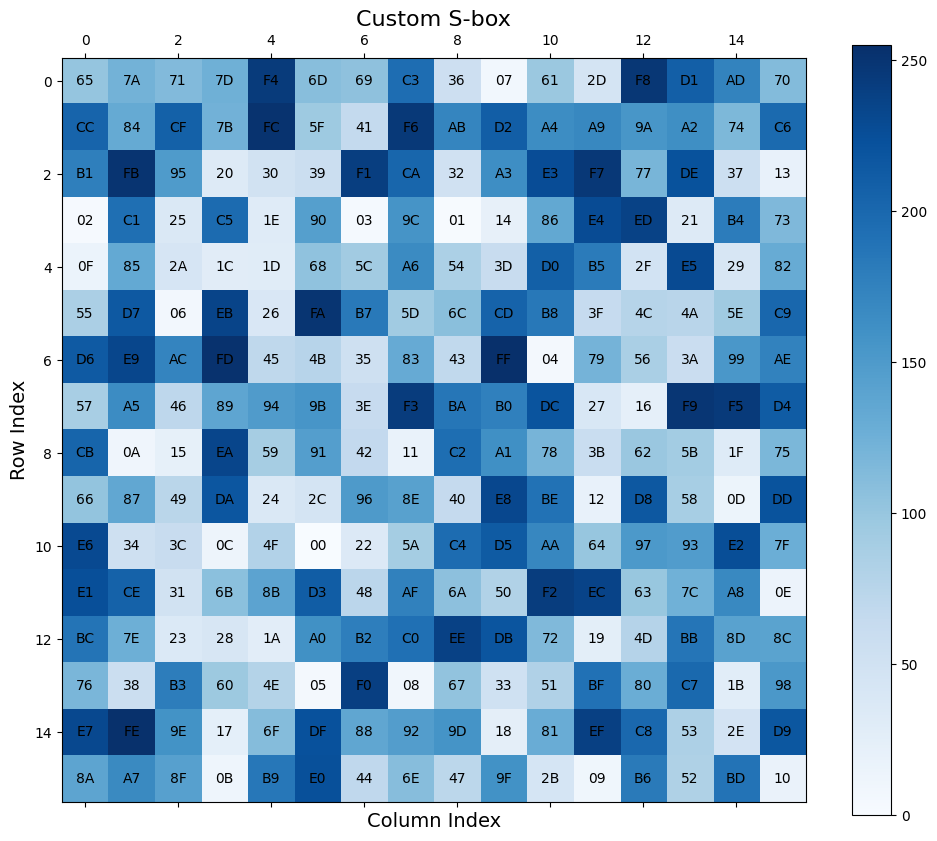

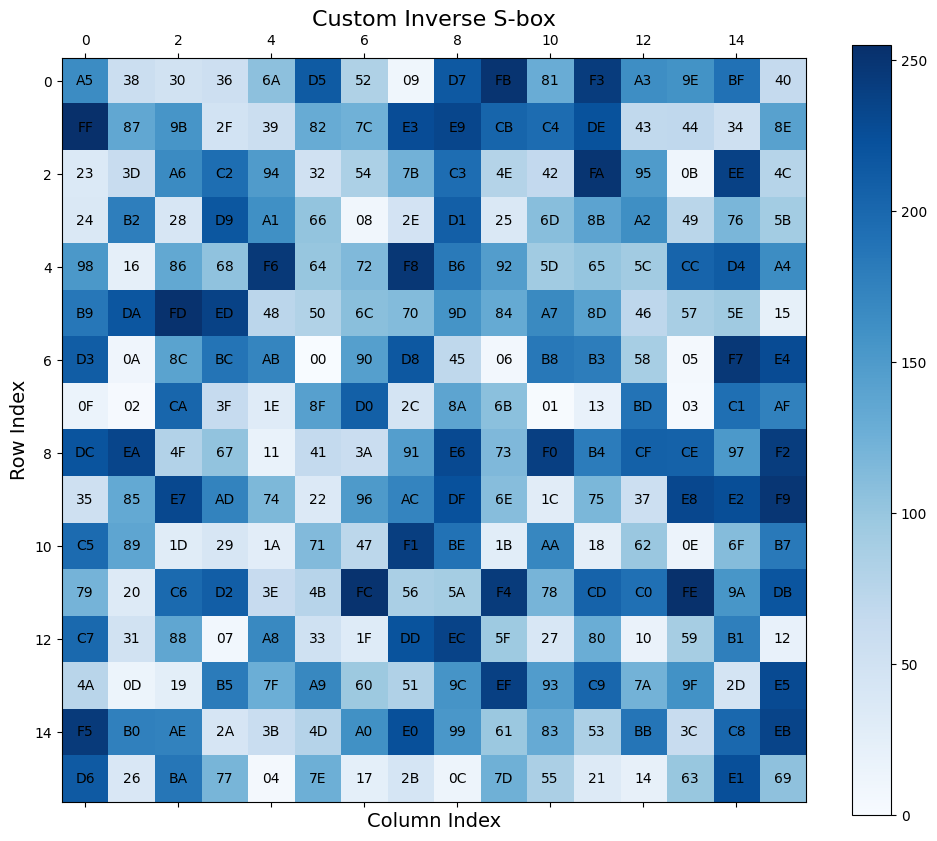

Testing S-box properties...
Bijectiveness: Passed
Balancedness: Passed
Non-linearity test failed for values: 0 and 2
Non-linearity: Failed
Differential Uniformity: Passed
Overall results: Failed


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Function to multiply two polynomials in GF(2^8)
def gf_multiply(x, y, modulus=0x11b):
    result = 0
    while y:
        if y & 1:
            result ^= x
        x <<= 1
        if x & 0x100:
            x ^= modulus
        y >>= 1
    return result

# Function to compute the multiplicative inverse in GF(2^8)
def gf_inverse(x):
    if x == 0:
        return 0
    for i in range(1, 256):
        if gf_multiply(x, i) == 1:
            return i
    return 0

# Custom affine transformation matrix and vector
affine_matrix = np.array([
    [1, 0, 0, 0, 1, 1, 1, 1],
    [1, 1, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 0, 0, 0, 1, 1],
    [1, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 1, 1]
], dtype=int)

affine_vector = np.array([1, 0, 1, 0, 0, 1, 1, 0], dtype=int)

def affine_transform(byte):
    bit_array = np.array([(byte >> i) & 1 for i in range(8)], dtype=int)
    transformed = np.dot(affine_matrix, bit_array) % 2
    transformed = (transformed + affine_vector) % 2
    result = 0
    for i in range(8):
        result |= (transformed[i] << i)
    return result

def generate_sbox():
    sbox = np.zeros(256, dtype=int)
    for i in range(256):
        inverse = gf_inverse(i)
        sbox[i] = affine_transform(inverse)
    return sbox

def generate_inverse_sbox(sbox):
    inverse_sbox = np.zeros(256, dtype=int)
    for i in range(256):
        inverse_sbox[sbox[i]] = i
    return inverse_sbox

def plot_sbox(sbox, title):
    sbox_matrix = sbox.reshape((16, 16))
    fig, ax = plt.subplots(figsize=(12, 10))
    cax = ax.matshow(sbox_matrix, cmap='Blues')

    for (i, j), val in np.ndenumerate(sbox_matrix):
        ax.text(j, i, f'{val:02X}', ha='center', va='center', color='black')

    plt.title(title, fontsize=16)
    plt.xlabel("Column Index", fontsize=14)
    plt.ylabel("Row Index", fontsize=14)
    fig.colorbar(cax)
    plt.show()

def test_sbox_properties(sbox, inverse_sbox):
    def test_bijectiveness(sbox, inverse_sbox):
        sbox_set = set(sbox)
        if len(sbox_set) != 256:
            print("S-box is not bijective: some values are repeated")
            return False
        for i in range(256):
            if inverse_sbox[sbox[i]] != i:
                print(f"S-box and inverse S-box mismatch at value: {i}")
                return False
        return True

    def test_balancedness(sbox):
        bit_counts = np.zeros(8, dtype=int)
        for value in sbox:
            for i in range(8):
                bit_counts[i] += (value >> i) & 1
        for count in bit_counts:
            if count != 128:
                print("S-box output is not balanced: bit counts are not equal")
                return False
        return True

    def test_non_linearity(sbox):
        non_linear = True
        for i in range(256):
            for j in range(i + 1, 256):
                if bin(sbox[i] ^ sbox[j]).count('1') <= 2:
                    non_linear = False
                    print(f"Non-linearity test failed for values: {i} and {j}")
                    return False
        return non_linear

    def test_diff_uniformity(sbox):
        max_diff = 0
        for a in range(1, 256):
            for b in range(256):
                diff_count = Counter((sbox[x] ^ sbox[x ^ a]) for x in range(256))
                max_diff = max(max_diff, max(diff_count.values()))
        if max_diff > 4:
            print(f"Differential uniformity test failed with max difference count: {max_diff}")
            return False
        return True

    print("Testing S-box properties...")
    
    bijective = test_bijectiveness(sbox, inverse_sbox)
    print(f"Bijectiveness: {'Passed' if bijective else 'Failed'}")

    balanced = test_balancedness(sbox)
    print(f"Balancedness: {'Passed' if balanced else 'Failed'}")

    non_linear = test_non_linearity(sbox)
    print(f"Non-linearity: {'Passed' if non_linear else 'Failed'}")

    diff_uniform = test_diff_uniformity(sbox)
    print(f"Differential Uniformity: {'Passed' if diff_uniform else 'Failed'}")

    return bijective, balanced, non_linear, diff_uniform

# Generate and test the S-box
sbox = generate_sbox()
inverse_sbox = generate_inverse_sbox(sbox)
plot_sbox(sbox, "Custom S-box")
plot_sbox(inverse_sbox, "Custom Inverse S-box")

# Test the properties of the generated S-box and its inverse
results = test_sbox_properties(sbox, inverse_sbox)
print(f"Overall results: {'Passed' if all(results) else 'Failed'}")

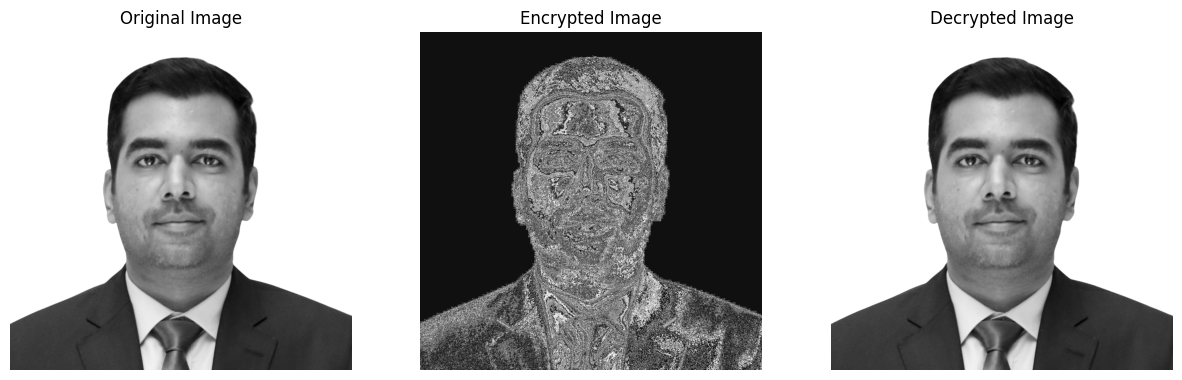

Decryption successful: The decrypted image matches the original image.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def encrypt_image(image, sbox):
    encrypted_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            encrypted_image[i, j] = sbox[image[i, j]]
    return encrypted_image

def decrypt_image(encrypted_image, inverse_sbox):
    decrypted_image = np.zeros_like(encrypted_image)
    for i in range(encrypted_image.shape[0]):
        for j in range(encrypted_image.shape[1]):
            decrypted_image[i, j] = inverse_sbox[encrypted_image[i, j]]
    return decrypted_image

# Load and convert image to grayscale
image_path = '/home/u22/MDPI_Electronics/20218257.jpg'  # Replace with your image path
image = Image.open(image_path).convert('L')  # Convert to grayscale
image = np.array(image)

# Encrypt the image
encrypted_image = encrypt_image(image, sbox)

# Decrypt the image
decrypted_image = decrypt_image(encrypted_image, inverse_sbox)

# Plot the original, encrypted, and decrypted images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(encrypted_image, cmap='gray')
axs[1].set_title('Encrypted Image')
axs[1].axis('off')

axs[2].imshow(decrypted_image, cmap='gray')
axs[2].set_title('Decrypted Image')
axs[2].axis('off')

plt.show()

# Verify if the decrypted image matches the original
if np.array_equal(image, decrypted_image):
    print("Decryption successful: The decrypted image matches the original image.")
else:
    print("Decryption failed: The decrypted image does not match the original image.")


In [11]:
import numpy as np

def avalanche_test(sbox):
    total_changes = 0
    num_tests = 0
    
    for byte in range(256):
        original_output = sbox[byte]
        original_bits = np.array([(original_output >> i) & 1 for i in range(8)])
        
        for bit in range(8):
            flipped_byte = byte ^ (1 << bit)  # Flip the current bit
            new_output = sbox[flipped_byte]
            new_bits = np.array([(new_output >> i) & 1 for i in range(8)])
            
            bit_changes = np.sum(original_bits != new_bits)
            total_changes += bit_changes
            num_tests += 1
    
    average_changes = total_changes / num_tests
    return average_changes

# Perform the Avalanche test on the S-box
average_changes = avalanche_test(sbox)
print(f"Average number of bit changes in the S-box output for a single bit flip in the input: {average_changes:.2f}")

# Check if the Avalanche criterion is satisfied (ideally 4 bits should change)
if 3.5 <= average_changes <= 4.5:
    print("Avalanche test passed")
else:
    print("Avalanche test failed")


Average number of bit changes in the S-box output for a single bit flip in the input: 4.04
Avalanche test passed


Testing other features

In [12]:
def strict_avalanche_test(sbox):
    sac_matrix = np.zeros((8, 8))

    for byte in range(256):
        original_output = sbox[byte]
        original_bits = np.array([(original_output >> i) & 1 for i in range(8)])
        
        for bit in range(8):
            flipped_byte = byte ^ (1 << bit)  # Flip the current bit
            new_output = sbox[flipped_byte]
            new_bits = np.array([(new_output >> i) & 1 for i in range(8)])
            
            for i in range(8):
                if original_bits[i] != new_bits[i]:
                    sac_matrix[bit][i] += 1
    
    sac_matrix /= 256
    return sac_matrix

# Perform the Strict Avalanche test on the S-box
sac_matrix = strict_avalanche_test(sbox)
print("Strict Avalanche Criterion (SAC) matrix:")
print(sac_matrix)

# Check if the SAC criterion is satisfied (each entry should be around 0.5)
sac_passed = np.all((sac_matrix >= 0.4) & (sac_matrix <= 0.6))
print(f"SAC test {'passed' if sac_passed else 'failed'}")


Strict Avalanche Criterion (SAC) matrix:
[[0.515625 0.515625 0.453125 0.5625   0.453125 0.484375 0.453125 0.5     ]
 [0.46875  0.484375 0.5625   0.5      0.484375 0.453125 0.5      0.53125 ]
 [0.515625 0.515625 0.5      0.46875  0.5625   0.5      0.53125  0.5     ]
 [0.53125  0.53125  0.46875  0.453125 0.5      0.53125  0.5      0.546875]
 [0.453125 0.5      0.453125 0.515625 0.5      0.5      0.546875 0.53125 ]
 [0.453125 0.515625 0.515625 0.46875  0.46875  0.546875 0.53125  0.53125 ]
 [0.53125  0.53125  0.46875  0.515625 0.46875  0.53125  0.53125  0.484375]
 [0.515625 0.5625   0.515625 0.53125  0.484375 0.53125  0.484375 0.515625]]
SAC test passed


In [13]:
def bit_independence_test(sbox):
    bic_matrix = np.zeros((8, 8))

    for byte in range(256):
        original_output = sbox[byte]
        original_bits = np.array([(original_output >> i) & 1 for i in range(8)])
        
        for bit in range(8):
            flipped_byte = byte ^ (1 << bit)  # Flip the current bit
            new_output = sbox[flipped_byte]
            new_bits = np.array([(new_output >> i) & 1 for i in range(8)])
            
            for i in range(8):
                for j in range(8):
                    if original_bits[i] != new_bits[i] and original_bits[j] != new_bits[j]:
                        bic_matrix[i][j] += 1
    
    bic_matrix /= 256
    return bic_matrix

# Perform the Bit Independence test on the S-box
bic_matrix = bit_independence_test(sbox)
print("Bit Independence Criterion (BIC) matrix:")
print(bic_matrix)

# Check if the BIC criterion is satisfied (each entry should be around 0.25)
bic_passed = np.all((bic_matrix >= 0.2) & (bic_matrix <= 0.3))
print(f"BIC test {'passed' if bic_passed else 'failed'}")


Bit Independence Criterion (BIC) matrix:
[[3.984375  2.0078125 2.015625  2.        1.9765625 1.9609375 1.9921875
  2.       ]
 [2.0078125 4.15625   1.96875   2.0390625 2.0546875 2.15625   2.109375
  2.2265625]
 [2.015625  1.96875   3.9375    1.875     1.8984375 2.0234375 1.9765625
  2.078125 ]
 [2.        2.0390625 1.875     4.015625  1.8984375 2.0703125 2.0703125
  2.0546875]
 [1.9765625 2.0546875 1.8984375 1.8984375 3.921875  1.953125  2.0234375
  1.96875  ]
 [1.9609375 2.15625   2.0234375 2.0703125 1.953125  4.078125  2.0546875
  2.0546875]
 [1.9921875 2.109375  1.9765625 2.0703125 2.0234375 2.0546875 4.078125
  2.0703125]
 [2.        2.2265625 2.078125  2.0546875 1.96875   2.0546875 2.0703125
  4.140625 ]]
BIC test failed


In [14]:
def linear_approximation_table(sbox):
    lat = np.zeros((256, 256), dtype=int)

    for a in range(256):
        for b in range(256):
            count = 0
            for x in range(256):
                input_parity = bin(a & x).count('1') % 2
                output_parity = bin(b & sbox[x]).count('1') % 2
                if input_parity == output_parity:
                    count += 1
            lat[a, b] = count - 128  # Subtract 128 to center the distribution

    return lat

# Perform the Linear Approximation Table (LAT) test on the S-box
lat = linear_approximation_table(sbox)
print("Linear Approximation Table (LAT):")
print(lat)

# Check the maximum bias
max_bias = np.max(np.abs(lat))
print(f"Maximum bias in LAT: {max_bias}")


Linear Approximation Table (LAT):
[[128   0   0 ...   0   0   0]
 [  0  12   0 ...  10  -2   2]
 [  0   2  -8 ...  -2 -12  -6]
 ...
 [  0  12  16 ...   8   8   0]
 [  0   2  -8 ...  -8  -6   4]
 [  0   2  -8 ...   6  -8   2]]
Maximum bias in LAT: 128


In [15]:
def differential_distribution_table(sbox):
    ddt = np.zeros((256, 256), dtype=int)

    for a in range(256):
        for b in range(256):
            count = 0
            for x in range(256):
                if sbox[x] ^ sbox[x ^ a] == b:
                    count += 1
            ddt[a, b] = count

    return ddt

# Perform the Differential Distribution Table (DDT) test on the S-box
ddt = differential_distribution_table(sbox)
print("Differential Distribution Table (DDT):")
print(ddt)

# Check the maximum value (excluding the first row and column which should be high)
max_ddt = np.max(ddt[1:, 1:])
print(f"Maximum value in DDT (excluding first row and column): {max_ddt}")


Differential Distribution Table (DDT):
[[256   0   0 ...   0   0   0]
 [  0   2   0 ...   0   0   2]
 [  0   0   0 ...   2   2   2]
 ...
 [  0   0   2 ...   2   0   2]
 [  0   0   0 ...   2   0   2]
 [  0   2   2 ...   2   2   2]]
Maximum value in DDT (excluding first row and column): 4


In [ ]:
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt

# Function to multiply two polynomials in GF(2^8)
def gf_multiply(x, y, modulus=0x11b):
    result = 0
    while y:
        if y & 1:
            result ^= x
        x <<= 1
        if x & 0x100:
            x ^= modulus
        y >>= 1
    return result

# Function to compute the multiplicative inverse in GF(2^8)
def gf_inverse(x):
    if x == 0:
        return 0
    for i in range(1, 256):
        if gf_multiply(x, i) == 1:
            return i
    return 0

# Custom affine transformation matrix and vector
affine_matrix = np.array([
    [1, 0, 0, 0, 1, 1, 1, 1],
    [1, 1, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 0, 0, 0, 1, 1],
    [1, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 1, 1]
], dtype=int)

affine_vector = np.array([1, 0, 1, 0, 0, 1, 1, 0], dtype=int)

def affine_transform(byte):
    bit_array = np.array([(byte >> i) & 1 for i in range(8)], dtype=int)
    transformed = np.dot(affine_matrix, bit_array) % 2
    transformed = (transformed + affine_vector) % 2
    result = 0
    for i in range(8):
        result |= (transformed[i] << i)
    return result

def generate_sbox():
    sbox = np.zeros(256, dtype=int)
    for i in range(256):
        inverse = gf_inverse(i)
        sbox[i] = affine_transform(inverse)
    return sbox

def generate_inverse_sbox(sbox):
    inverse_sbox = np.zeros(256, dtype=int)
    for i in range(256):
        inverse_sbox[sbox[i]] = i
    return inverse_sbox

def plot_sbox(sbox, title):
    sbox_matrix = sbox.reshape((16, 16))
    fig, ax = plt.subplots(figsize=(12, 10))
    cax = ax.matshow(sbox_matrix, cmap='Blues')

    for (i, j), val in np.ndenumerate(sbox_matrix):
        ax.text(j, i, f'{val:02X}', ha='center', va='center', color='black')

    plt.title(title, fontsize=16)
    plt.xlabel("Column Index", fontsize=14)
    plt.ylabel("Row Index", fontsize=14)
    fig.colorbar(cax)
    plt.show()

def test_sbox_properties(sbox, inverse_sbox):
    def test_bijectiveness(sbox, inverse_sbox):
        sbox_set = set(sbox)
        if len(sbox_set) != 256:
            print("S-box is not bijective: some values are repeated")
            return False
        for i in range(256):
            if inverse_sbox[sbox[i]] != i:
                print(f"S-box and inverse S-box mismatch at value: {i}")
                return False
        return True

    def test_balancedness(sbox):
        bit_counts = np.zeros(8, dtype=int)
        for value in sbox:
            for i in range(8):
                bit_counts[i] += (value >> i) & 1
        for count in bit_counts:
            if count != 128:
                print("S-box output is not balanced: bit counts are not equal")
                return False
        return True

    def test_non_linearity(sbox):
        non_linear = True
        for i in range(256):
            for j in range(i + 1, 256):
                if bin(sbox[i] ^ sbox[j]).count('1') <= 2:
                    non_linear = False
                    print(f"Non-linearity test failed for values: {i} and {j}")
                    return False
        return non_linear

    def test_diff_uniformity(sbox):
        max_diff = 0
        for a in range(1, 256):
            for b in range(256):
                diff_count = Counter((sbox[x] ^ sbox[x ^ a]) for x in range(256))
                max_diff = max(max_diff, max(diff_count.values()))
        if max_diff > 4:
            print(f"Differential uniformity test failed with max difference count: {max_diff}")
            return False
        return True

    print("Testing S-box properties...")
    
    bijective = test_bijectiveness(sbox, inverse_sbox)
    print(f"Bijectiveness: {'Passed' if bijective else 'Failed'}")

    balanced = test_balancedness(sbox)
    print(f"Balancedness: {'Passed' if balanced else 'Failed'}")

    non_linear = test_non_linearity(sbox)
    print(f"Non-linearity: {'Passed' if non_linear else 'Failed'}")

    diff_uniform = test_diff_uniformity(sbox)
    print(f"Differential Uniformity: {'Passed' if diff_uniform else 'Failed'}")

    return bijective, balanced, non_linear, diff_uniform

# Fitness function for the genetic algorithm
def fitness(sbox):
    sac_matrix = strict_avalanche_test(sbox)
    bic_matrix = bit_independence_test(sbox)
    lat = linear_approximation_table(sbox)
    ddt = differential_distribution_table(sbox)

    sac_score = np.sum((sac_matrix >= 0.4) & (sac_matrix <= 0.6))
    bic_score = np.sum((bic_matrix >= 0.2) & (bic_matrix <= 0.3))
    lat_bias = np.max(np.abs(lat))
    ddt_max = np.max(ddt[1:, 1:])

    fitness_score = sac_score + bic_score - lat_bias - ddt_max
    return fitness_score

# Crossover function for the genetic algorithm
def crossover(sbox1, sbox2):
    crossover_point = random.randint(1, 255)
    child1 = np.concatenate((sbox1[:crossover_point], sbox2[crossover_point:]))
    child2 = np.concatenate((sbox2[:crossover_point], sbox1[crossover_point:]))
    return child1, child2

# Mutation function for the genetic algorithm
def mutate(sbox, mutation_rate=0.05):
    for i in range(256):
        if random.random() < mutation_rate:
            swap_index = random.randint(0, 255)
            sbox[i], sbox[swap_index] = sbox[swap_index], sbox[i]
    return sbox

# Generate initial population for the genetic algorithm
def generate_initial_population(size=100):
    population = []
    for _ in range(size):
        sbox = np.random.permutation(256)
        population.append(sbox)
    return population

# Select parents for the genetic algorithm
def select_parents(population, fitnesses, num_parents=50):
    min_fitness = min(fitnesses)
    if min_fitness < 0:
        fitnesses = [f - min_fitness + 1 for f in fitnesses]
    parents = random.choices(population, weights=fitnesses, k=num_parents)
    return parents

# Genetic algorithm to optimize the S-box
def genetic_algorithm(pop_size=100, generations=100, mutation_rate=0.05):
    population = generate_initial_population(pop_size)
    
    for generation in range(generations):
        fitnesses = [fitness(sbox) for sbox in population]
        print(f"Generation {generation}, Best fitness: {max(fitnesses)}")

        parents = select_parents(population, fitnesses)
        next_generation = []

        while len(next_generation) < pop_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            next_generation.append(mutate(child1, mutation_rate))
            next_generation.append(mutate(child2, mutation_rate))

        population = next_generation

    best_sbox = max(population, key=fitness)
    return best_sbox

# Run the genetic algorithm to optimize the S-box
optimized_sbox = genetic_algorithm(pop_size=100, generations=100, mutation_rate=0.05)
inverse_optimized_sbox = generate_inverse_sbox(optimized_sbox)

# Plot the optimized S-box and its inverse
plot_sbox(optimized_sbox, "Optimized S-box")
plot_sbox(inverse_optimized_sbox, "Optimized Inverse S-box")

# Test the properties of the optimized S-box and its inverse
results = test_sbox_properties(optimized_sbox, inverse_optimized_sbox)
print(f"Overall results: {'Passed' if all(results) else 'Failed'}")

# Additional helper functions for the tests
def strict_avalanche_test(sbox):
    sac_matrix = np.zeros((8, 8))

    for byte in range(256):
        original_output = sbox[byte]
        original_bits = np.array([(original_output >> i) & 1 for i in range(8)])
        
        for bit in range(8):
            flipped_byte = byte ^ (1 << bit)  # Flip the current bit
            new_output = sbox[flipped_byte]
            new_bits = np.array([(new_output >> i) & 1 for i in range(8)])
            
            for i in range(8):
                if original_bits[i] != new_bits[i]:
                    sac_matrix[bit][i] += 1
    
    sac_matrix /= 256
    return sac_matrix

def bit_independence_test(sbox):
    bic_matrix = np.zeros((8, 8))

    for byte in range(256):
        original_output = sbox[byte]
        original_bits = np.array([(original_output >> i) & 1 for i in range(8)])
        
        for bit in range(8):
            flipped_byte = byte ^ (1 << bit)  # Flip the current bit
            new_output = sbox[flipped_byte]
            new_bits = np.array([(new_output >> i) & 1 for i in range(8)])
            
            for i in range(8):
                for j in range(8):
                    if original_bits[i] != new_bits[i] and original_bits[j] != new_bits[j]:
                        bic_matrix[i][j] += 1
    
    bic_matrix /= 256
    return bic_matrix

def linear_approximation_table(sbox):
    lat = np.zeros((256, 256), dtype=int)

    for a in range(256):
        for b in range(256):
            count = 0
            for x in range(256):
                input_parity = bin(a & x).count('1') % 2
                output_parity = bin(b & sbox[x]).count('1') % 2
                if input_parity == output_parity:
                    count += 1
            lat[a, b] = count - 128  # Subtract 128 to center the distribution

    return lat

def differential_distribution_table(sbox):
    ddt = np.zeros((256, 256), dtype=int)

    for a in range(256):
        for b in range(256):
            count = 0
            for x in range(256):
                if sbox[x] ^ sbox[x ^ a] == b:
                    count += 1
            ddt[a, b] = count

    return ddt


Concurrent

Generation 0, Best fitness: -74
Generation 1, Best fitness: -74
Generation 2, Best fitness: -74
Generation 3, Best fitness: -74
Generation 4, Best fitness: -74
Generation 5, Best fitness: -74
Generation 6, Best fitness: -74
Generation 7, Best fitness: -74
Generation 8, Best fitness: -74
Generation 9, Best fitness: -74
Generation 10, Best fitness: -74
Generation 11, Best fitness: -74
Generation 12, Best fitness: -74
Generation 13, Best fitness: -74
Generation 14, Best fitness: -74
Generation 15, Best fitness: -74
Generation 16, Best fitness: -74
Generation 17, Best fitness: -74
Generation 18, Best fitness: -74
Generation 19, Best fitness: -74
Generation 20, Best fitness: -74
Generation 21, Best fitness: -74
Generation 22, Best fitness: -74
Generation 23, Best fitness: -74
Generation 24, Best fitness: -74
Generation 25, Best fitness: -74
Generation 26, Best fitness: -74
Generation 27, Best fitness: -74
Generation 28, Best fitness: -74
Generation 29, Best fitness: -74
Generation 30, Best 

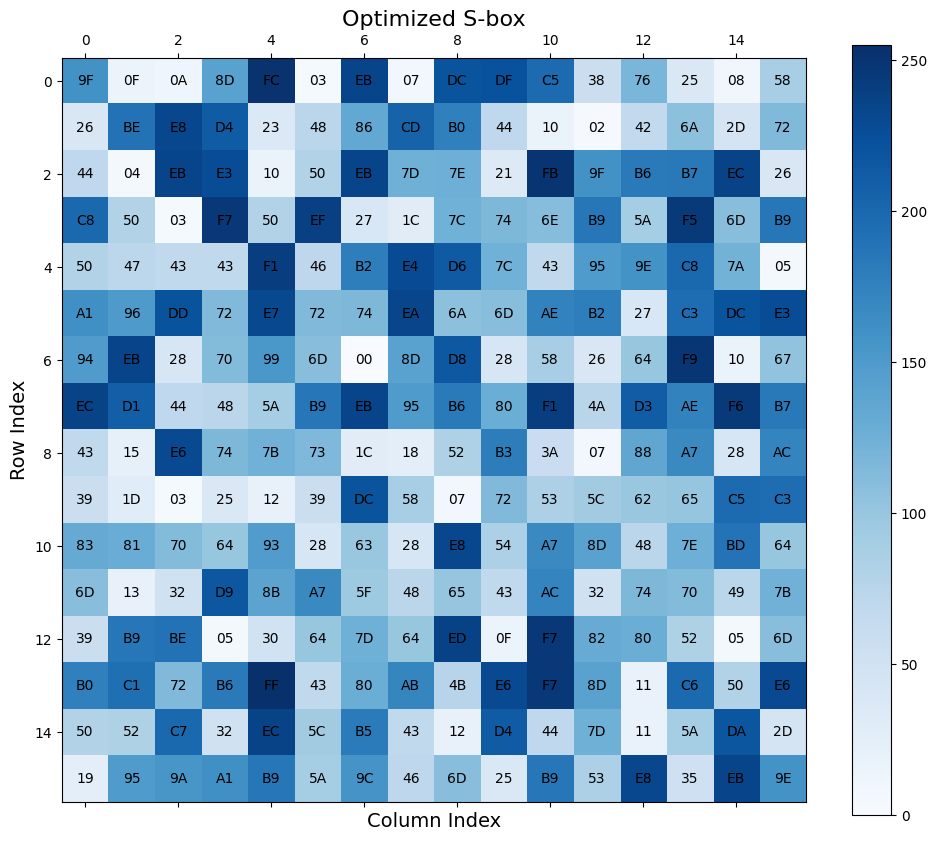

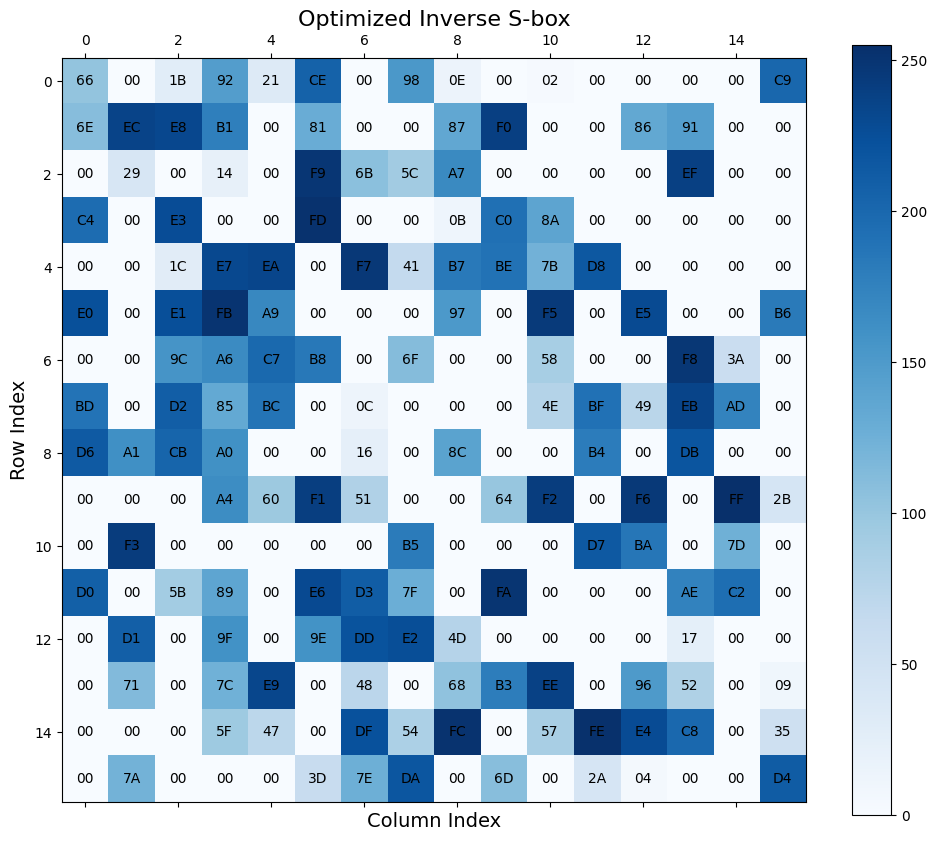

Testing S-box properties...
S-box is not bijective: some values are repeated
Bijectiveness: Failed
S-box output is not balanced: bit counts are not equal
Balancedness: Failed
Non-linearity test failed for values: 0 and 1
Non-linearity: Failed
Differential uniformity test failed with max difference count: 10
Differential Uniformity: Failed
Overall results: Failed


In [18]:
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Function to multiply two polynomials in GF(2^8)
def gf_multiply(x, y, modulus=0x11b):
    result = 0
    while y:
        if y & 1:
            result ^= x
        x <<= 1
        if x & 0x100:
            x ^= modulus
        y >>= 1
    return result

# Function to compute the multiplicative inverse in GF(2^8)
def gf_inverse(x):
    if x == 0:
        return 0
    for i in range(1, 256):
        if gf_multiply(x, i) == 1:
            return i
    return 0

# Custom affine transformation matrix and vector
affine_matrix = np.array([
    [1, 0, 0, 0, 1, 1, 1, 1],
    [1, 1, 0, 0, 0, 1, 1, 1],
    [1, 1, 1, 0, 0, 0, 1, 1],
    [1, 1, 1, 1, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 1, 1, 1, 1, 1]
], dtype=int)

affine_vector = np.array([1, 0, 1, 0, 0, 1, 1, 0], dtype=int)

def affine_transform(byte):
    bit_array = np.array([(byte >> i) & 1 for i in range(8)], dtype=int)
    transformed = np.dot(affine_matrix, bit_array) % 2
    transformed = (transformed + affine_vector) % 2
    result = 0
    for i in range(8):
        result |= (transformed[i] << i)
    return result

def generate_sbox():
    sbox = np.zeros(256, dtype=int)
    for i in range(256):
        inverse = gf_inverse(i)
        sbox[i] = affine_transform(inverse)
    return sbox

def generate_inverse_sbox(sbox):
    inverse_sbox = np.zeros(256, dtype=int)
    for i in range(256):
        inverse_sbox[sbox[i]] = i
    return inverse_sbox

def plot_sbox(sbox, title):
    sbox_matrix = sbox.reshape((16, 16))
    fig, ax = plt.subplots(figsize=(12, 10))
    cax = ax.matshow(sbox_matrix, cmap='Blues')

    for (i, j), val in np.ndenumerate(sbox_matrix):
        ax.text(j, i, f'{val:02X}', ha='center', va='center', color='black')

    plt.title(title, fontsize=16)
    plt.xlabel("Column Index", fontsize=14)
    plt.ylabel("Row Index", fontsize=14)
    fig.colorbar(cax)
    plt.show()

def test_sbox_properties(sbox, inverse_sbox):
    def test_bijectiveness(sbox, inverse_sbox):
        sbox_set = set(sbox)
        if len(sbox_set) != 256:
            print("S-box is not bijective: some values are repeated")
            return False
        for i in range(256):
            if inverse_sbox[sbox[i]] != i:
                print(f"S-box and inverse S-box mismatch at value: {i}")
                return False
        return True

    def test_balancedness(sbox):
        bit_counts = np.zeros(8, dtype=int)
        for value in sbox:
            for i in range(8):
                bit_counts[i] += (value >> i) & 1
        for count in bit_counts:
            if count != 128:
                print("S-box output is not balanced: bit counts are not equal")
                return False
        return True

    def test_non_linearity(sbox):
        non_linear = True
        for i in range(256):
            for j in range(i + 1, 256):
                if bin(sbox[i] ^ sbox[j]).count('1') <= 2:
                    non_linear = False
                    print(f"Non-linearity test failed for values: {i} and {j}")
                    return False
        return non_linear

    def test_diff_uniformity(sbox):
        max_diff = 0
        for a in range(1, 256):
            for b in range(256):
                diff_count = Counter((sbox[x] ^ sbox[x ^ a]) for x in range(256))
                max_diff = max(max_diff, max(diff_count.values()))
        if max_diff > 4:
            print(f"Differential uniformity test failed with max difference count: {max_diff}")
            return False
        return True

    print("Testing S-box properties...")
    
    bijective = test_bijectiveness(sbox, inverse_sbox)
    print(f"Bijectiveness: {'Passed' if bijective else 'Failed'}")

    balanced = test_balancedness(sbox)
    print(f"Balancedness: {'Passed' if balanced else 'Failed'}")

    non_linear = test_non_linearity(sbox)
    print(f"Non-linearity: {'Passed' if non_linear else 'Failed'}")

    diff_uniform = test_diff_uniformity(sbox)
    print(f"Differential Uniformity: {'Passed' if diff_uniform else 'Failed'}")

    return bijective, balanced, non_linear, diff_uniform

# Fitness function for the genetic algorithm
def fitness(sbox):
    sac_matrix = strict_avalanche_test(sbox)
    bic_matrix = bit_independence_test(sbox)
    lat = linear_approximation_table(sbox)
    ddt = differential_distribution_table(sbox)

    sac_score = np.sum((sac_matrix >= 0.4) & (sac_matrix <= 0.6))
    bic_score = np.sum((bic_matrix >= 0.2) & (bic_matrix <= 0.3))
    lat_bias = np.max(np.abs(lat))
    ddt_max = np.max(ddt[1:, 1:])

    fitness_score = sac_score + bic_score - lat_bias - ddt_max
    return fitness_score

# Crossover function for the genetic algorithm
def crossover(sbox1, sbox2):
    crossover_point = random.randint(1, 255)
    child1 = np.concatenate((sbox1[:crossover_point], sbox2[crossover_point:]))
    child2 = np.concatenate((sbox2[:crossover_point], sbox1[crossover_point:]))
    return child1, child2

# Mutation function for the genetic algorithm
def mutate(sbox, mutation_rate=0.05):
    for i in range(256):
        if random.random() < mutation_rate:
            swap_index = random.randint(0, 255)
            sbox[i], sbox[swap_index] = sbox[swap_index], sbox[i]
    return sbox

# Generate initial population for the genetic algorithm
def generate_initial_population(size=100):
    population = []
    for _ in range(size):
        sbox = np.random.permutation(256)
        population.append(sbox)
    return population

# Select parents for the genetic algorithm
def select_parents(population, fitnesses, num_parents=50):
    min_fitness = min(fitnesses)
    if min_fitness < 0:
        fitnesses = [f - min_fitness + 1 for f in fitnesses]
    parents = random.choices(population, weights=fitnesses, k=num_parents)
    return parents

# Genetic algorithm to optimize the S-box
def genetic_algorithm(pop_size=100, generations=50, mutation_rate=0.05):
    population = generate_initial_population(pop_size)
    
    for generation in range(generations):
        with ThreadPoolExecutor() as executor:
            fitnesses = list(executor.map(fitness, population))
        
        print(f"Generation {generation}, Best fitness: {max(fitnesses)}")

        parents = select_parents(population, fitnesses)
        next_generation = []

        while len(next_generation) < pop_size:
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            next_generation.append(mutate(child1, mutation_rate))
            next_generation.append(mutate(child2, mutation_rate))

        population = next_generation

    best_sbox = max(population, key=fitness)
    return best_sbox

# Run the genetic algorithm to optimize the S-box
optimized_sbox = genetic_algorithm(pop_size=100, generations=50, mutation_rate=0.05)
inverse_optimized_sbox = generate_inverse_sbox(optimized_sbox)

# Plot the optimized S-box and its inverse
plot_sbox(optimized_sbox, "Optimized S-box")
plot_sbox(inverse_optimized_sbox, "Optimized Inverse S-box")

# Test the properties of the optimized S-box and its inverse
results = test_sbox_properties(optimized_sbox, inverse_optimized_sbox)
print(f"Overall results: {'Passed' if all(results) else 'Failed'}")

# Additional helper functions for the tests
def strict_avalanche_test(sbox):
    sac_matrix = np.zeros((8, 8))

    for byte in range(256):
        original_output = sbox[byte]
        original_bits = np.array([(original_output >> i) & 1 for i in range(8)])
        
        for bit in range(8):
            flipped_byte = byte ^ (1 << bit)  # Flip the current bit
            new_output = sbox[flipped_byte]
            new_bits = np.array([(new_output >> i) & 1 for i in range(8)])
            
            for i in range(8):
                if original_bits[i] != new_bits[i]:
                    sac_matrix[bit][i] += 1
    
    sac_matrix /= 256
    return sac_matrix

def bit_independence_test(sbox):
    bic_matrix = np.zeros((8, 8))

    for byte in range(256):
        original_output = sbox[byte]
        original_bits = np.array([(original_output >> i) & 1 for i in range(8)])
        
        for bit in range(8):
            flipped_byte = byte ^ (1 << bit)  # Flip the current bit
            new_output = sbox[flipped_byte]
            new_bits = np.array([(new_output >> i) & 1 for i in range(8)])
            
            for i in range(8):
                for j in range(8):
                    if original_bits[i] != new_bits[i] and original_bits[j] != new_bits[j]:
                        bic_matrix[i][j] += 1
    
    bic_matrix /= 256
    return bic_matrix

def linear_approximation_table(sbox):
    lat = np.zeros((256, 256), dtype=int)

    for a in range(256):
        for b in range(256):
            count = 0
            for x in range(256):
                input_parity = bin(a & x).count('1') % 2
                output_parity = bin(b & sbox[x]).count('1') % 2
                if input_parity == output_parity:
                    count += 1
            lat[a, b] = count - 128  # Subtract 128 to center the distribution

    return lat

def differential_distribution_table(sbox):
    ddt = np.zeros((256, 256), dtype=int)

    for a in range(256):
        for b in range(256):
            count = 0
            for x in range(256):
                if sbox[x] ^ sbox[x ^ a] == b:
                    count += 1
            ddt[a, b] = count

    return ddt
